Import Library dan Dataset

In [1]:
# Import Library
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [2]:
# Import Dataset
data_dir = '/content/drive/MyDrive/PMDPM/Dataset Batik'

Data Preprocessing

In [3]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),  # Menyesuaikan ukuran gambar menjadi 224x224
    batch_size=16,  # Mengatur ukuran batch, yaitu 16 data di dalam setiap batch
)

class_names = data.class_names
print(class_names)


# Menghitung jumlah gambar per kelas
hitung_gambar = {}
for file_path in data.file_paths:
    class_name = file_path.split(os.sep)[-2]
    if class_name in hitung_gambar:
        hitung_gambar[class_name] += 1
    else:
        hitung_gambar[class_name] = 1

print("Jumlah gambar dalam setiap kelas:", hitung_gambar)

Found 792 files belonging to 4 classes.
['Batik Celup', 'Batik Kawung', 'Batik Megamendung', 'Batik Parang']
Jumlah gambar dalam setiap kelas: {'Batik Parang': 203, 'Batik Celup': 197, 'Batik Megamendung': 197, 'Batik Kawung': 195}


In [4]:
# Membagi data ke dalam batch
data_iterator = data.as_numpy_iterator()
print("data_iterator", data_iterator)

data_iterator <tensorflow.python.data.ops.dataset_ops.NumpyIterator object at 0x78a4980c01c0>


In [5]:
batch = data_iterator.next()
print("batch", batch)

batch (array([[[[ 25.022316  ,  81.022316  ,  56.022316  ],
         [ 28.033499  ,  84.03349   ,  59.033497  ],
         [ 31.060244  ,  87.06024   ,  62.06024   ],
         ...,
         [ 14.084799  ,  59.0848    ,  38.0848    ],
         [ 12.031254  ,  55.049088  ,  35.04017   ],
         [ 13.995554  ,  55.997807  ,  35.997803  ]],

        [[ 31.984373  ,  87.997765  ,  62.99777   ],
         [ 34.006653  ,  90.02004   ,  65.02004   ],
         [ 38.006695  ,  94.020096  ,  69.020096  ],
         ...,
         [ 22.026886  ,  67.046974  ,  46.04028   ],
         [ 20.013351  ,  65.01349   ,  44.013443  ],
         [ 13.993414  ,  56.000145  ,  35.997902  ]],

        [[ 29.0156    ,  87.01565   ,  62.015625  ],
         [ 31.020164  ,  89.042336  ,  64.03125   ],
         [ 34.04439   ,  92.04465   ,  67.044525  ],
         ...,
         [ 20.988998  ,  68.989     ,  46.989     ],
         [ 19.950895  ,  64.97099   ,  43.964294  ],
         [ 11.175961  ,  53.193825  ,  33.1915

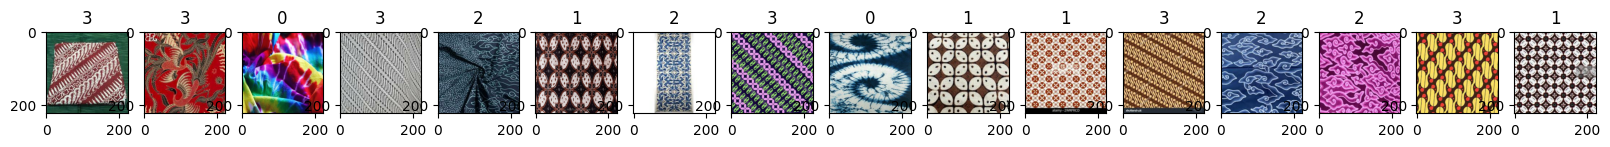

In [6]:
# Display gambar
fig, ax = plt.subplots(ncols=16, figsize=(20,20))
for idx, img in enumerate(batch[0][:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
# Normalisasi data
# Memetakan fungsi lambda ke dataset untuk normalisasi data gambar
data = data.map(lambda x, y: (x / 255.0, y))  # Membagi nilai pixel dengan 255 untuk mendapatkan rentang [0,1]
print("Tipe data setelah normalisasi: {}".format(data.element_spec))
print("Bentuk data setelah normalisasi: {}".format(data.element_spec))
print("Jumlah data", len(data))

Tipe data setelah normalisasi: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Bentuk data setelah normalisasi: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Jumlah data 50


In [8]:
# Membagi data untuk training, validasi, dan testing
dataset_size = len(data)
train_size = int(dataset_size * 0.8)  # 80% untuk training
val_size = int(dataset_size * 0.1)    # 10% untuk validasi
test_size = dataset_size - train_size - val_size  # 10% untuk testing

# Membagi dataset
train = data.take(train_size)  # Ambil data untuk training
val = data.skip(train_size).take(val_size)  # Lewatkan data training, ambil data untuk validasi
test = data.skip(train_size + val_size).take(test_size)  # Lewatkan data training dan validasi, ambil sisa untuk testing

# Print ukuran dari masing-masing bagian dataset
print(f"Ukuran training set: {train_size}")
print(f"Ukuran validation set: {val_size}")
print(f"Ukuran test set: {test_size}")

Ukuran training set: 40
Ukuran validation set: 5
Ukuran test set: 5


Pembuatan Model VGG-16

In [9]:
def build_vgg_model(input_shape, jumlah_kelas):
    vgg_input = Input(shape=input_shape)

    # Block 1
    conv1 = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(vgg_input)
    conv2 = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv2)

    # Block 2
    conv3 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
    conv4 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
    pool2 = MaxPooling2D((2, 2))(conv4)

    # Block 3
    conv5 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
    conv6 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
    conv7 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
    pool3 = MaxPooling2D((2, 2))(conv7)

    # Block 4
    conv8 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
    conv9 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
    conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
    pool4 = MaxPooling2D((2, 2))(conv10)

    # Block 5
    conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
    conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
    conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
    pool5 = MaxPooling2D((2, 2))(conv13)

    # Fully connected layers
    flat = Flatten()(pool5)
    dense1 = Dense(4096, activation="relu")(flat)
    dense2 = Dense(4096, activation="relu")(dense1)
    output = Dense(jumlah_kelas, activation="softmax")(dense2)

    model = Model(inputs=vgg_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [23]:
# Membangun model dengan fungsi yang sudah dibuat
vgg_model = build_vgg_model(input_shape=(224, 224, 3), jumlah_kelas = 4)
vgg_model.summary()  # Menampilkan ringkasan model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                           

Pelatihan (Training) VGG-16

In [24]:
# Melatih model dengan 50 epoch
vgg_history = vgg_model.fit(train, epochs=100, validation_data=val)  # Melatih model dengan data training dan validasi

Epoch 1/100
40/40 [==============================] - 15s 318ms/step - loss: 1.3864 - accuracy: 0.2625 - val_loss: 1.3886 - val_accuracy: 0.2375
Epoch 2/100
40/40 [==============================] - 13s 318ms/step - loss: 1.3860 - accuracy: 0.2609 - val_loss: 1.3841 - val_accuracy: 0.2375
Epoch 3/100
40/40 [==============================] - 13s 314ms/step - loss: 1.3857 - accuracy: 0.2516 - val_loss: 1.3919 - val_accuracy: 0.3000
Epoch 4/100
40/40 [==============================] - 13s 314ms/step - loss: 1.3848 - accuracy: 0.2906 - val_loss: 1.3881 - val_accuracy: 0.3375
Epoch 5/100
40/40 [==============================] - 13s 310ms/step - loss: 1.3853 - accuracy: 0.2531 - val_loss: 1.3933 - val_accuracy: 0.2250
Epoch 6/100
40/40 [==============================] - 13s 311ms/step - loss: 1.3840 - accuracy: 0.2828 - val_loss: 1.3964 - val_accuracy: 0.2000
Epoch 7/100
40/40 [==============================] - 13s 311ms/step - loss: 1.3845 - accuracy: 0.2625 - val_loss: 1.3836 - val_accuracy:

Evaluasi Model

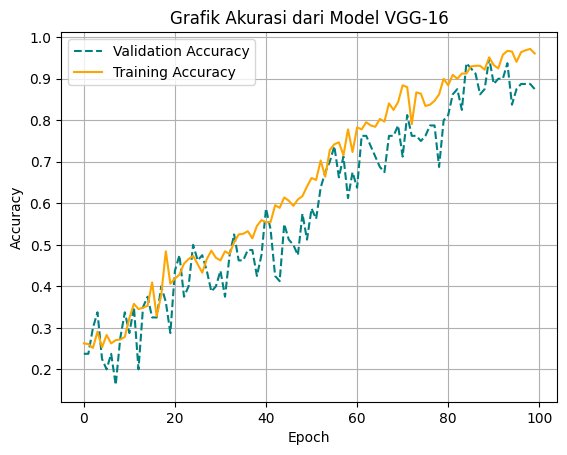

In [25]:
# Membuat grafik visualisasi untuk Akurasi model Alexnet
fig, ax1 = plt.subplots()
ax1.plot(vgg_history.history['val_accuracy'], color='teal', linestyle='--', label='Validation Accuracy')
ax1.plot(vgg_history.history['accuracy'], color='orange', linestyle='-', label='Training Accuracy')
ax1.set_title('Grafik Akurasi dari Model VGG-16')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc="upper left")
ax1.grid(True)

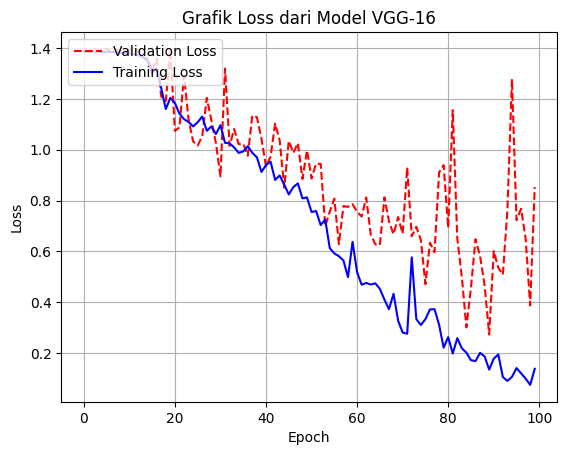

In [26]:
# Membuat grafik visualisasi untuk Loss model Alexnet
fig, ax2 = plt.subplots()
ax2.plot(vgg_history.history['val_loss'], color='red', linestyle='--', label='Validation Loss')
ax2.plot(vgg_history.history['loss'], color='blue', linestyle='-', label='Training Loss')
ax2.set_title('Grafik Loss dari Model VGG-16')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc="upper left")
ax2.grid(True)

In [31]:
# Evaluasi model menggunakan data tes
test_loss, test_accuracy = vgg_model.evaluate(test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

5/5 [==============================] - 4s 75ms/step - loss: 1.0053 - accuracy: 0.8611
Test Loss: 1.0052587985992432
Test Accuracy: 0.8611111044883728


In [33]:
# Eksport model yang sudah jadi
vgg_model.save('/content/drive/MyDrive/PMDPM/Model/Proyek UAS_A_Salam BE_VGG-16 CNN.h5')